In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
from src.fd_scheme import fd_solve
from src.analytical import u_exact
from src.plotting import plot_solution, plot_training_loss, plot_all_heatmaps, plot_scheme_errors_t1, plot_scheme_errors_t2, plot_3d_surface, subplot_3d_surface
from src.nn.model import MLP
from src.nn.train import train_pinn
from src.nn.evaluation import compare_nn_and_exact, test_explicit_scheme, evaluate_pinn
from src.experiment import run_architecture_sweep

# Part B
Plots for $\Delta x = 1/10$ and $\Delta t = 1/100$

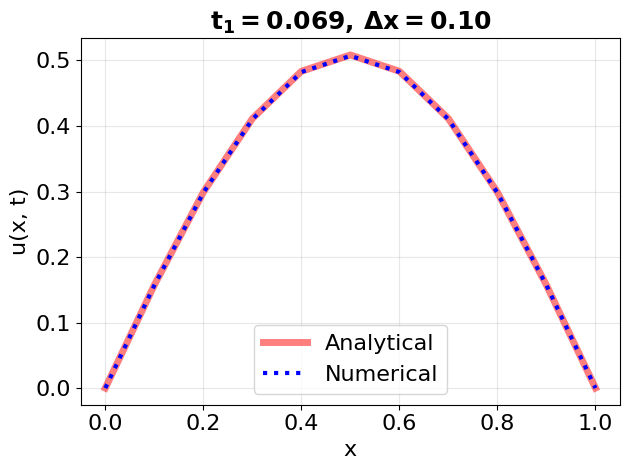

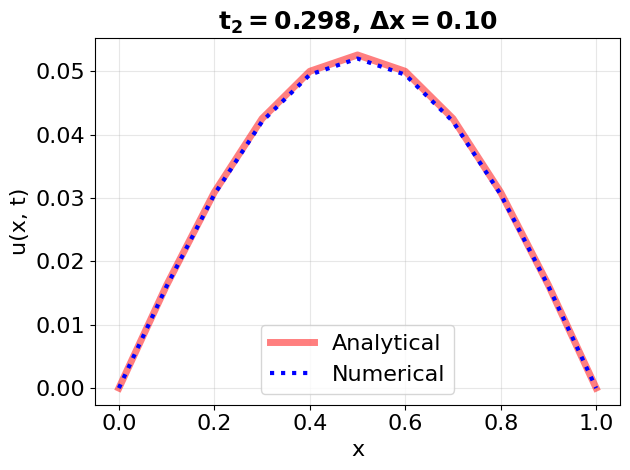

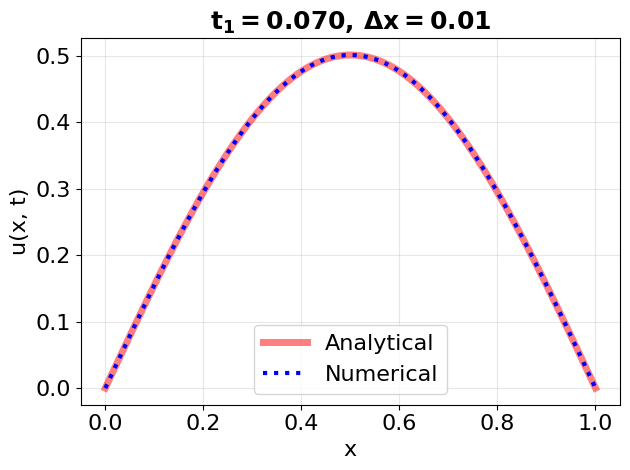

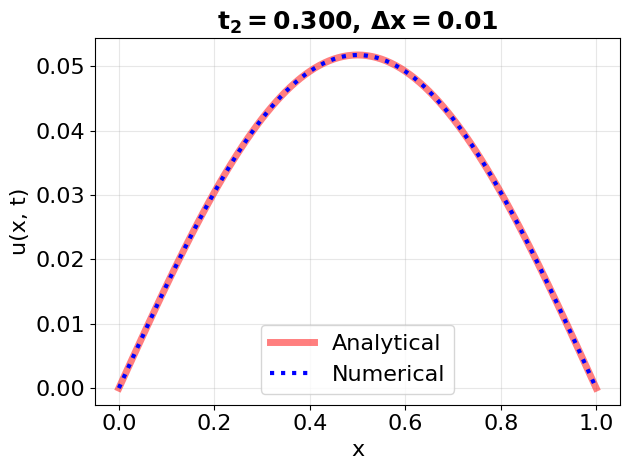

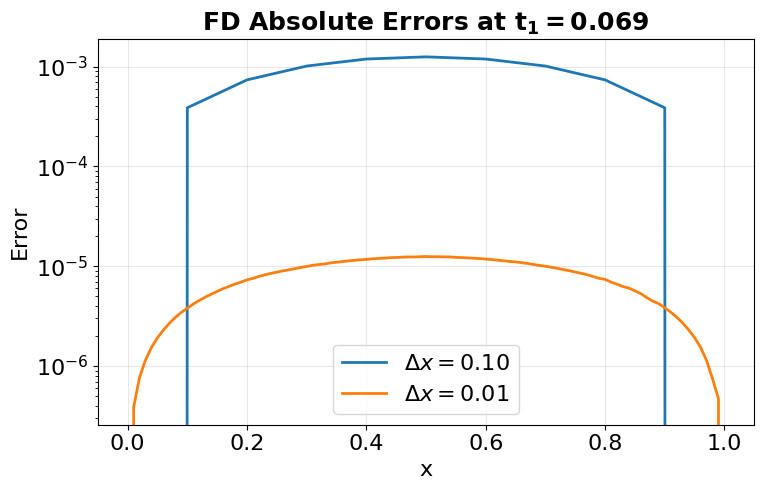

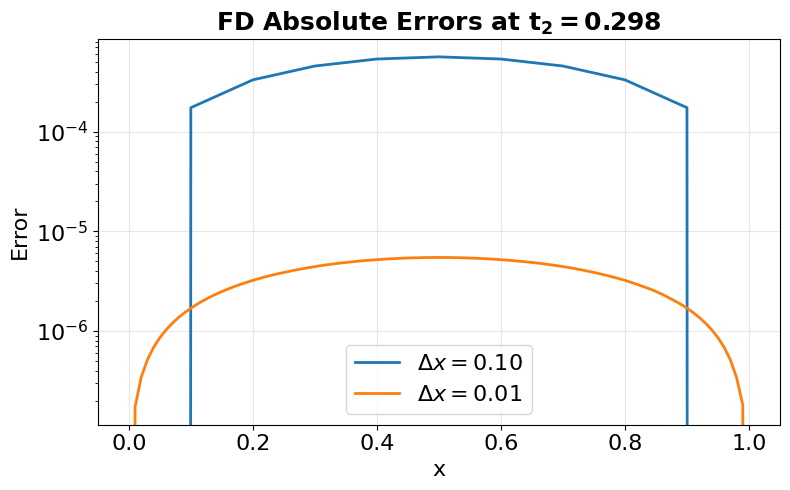

In [2]:
errors = []
errors.append(test_explicit_scheme(Nx=10))
errors.append(test_explicit_scheme(Nx=100))

plot_scheme_errors_t1(errors, title=rf"FD Absolute Errors at $\mathbf{{t_1 = {errors[0]['t1']:.3f}}}$", filepath="../figs/errors_t1.pdf")
plot_scheme_errors_t2(errors, title=rf"FD Absolute Errors at $\mathbf{{t_2 = {errors[0]['t2']:.3f}}}$", filepath="../figs/errors_t2.pdf")

# Part C
Solving same problem as for part b, but now using PINNS

In [ ]:
# Finite Difference scheme
u_fd, x, t = fd_solve(Nx=100, T=0.5, alpha=0.4) 


# TODO: plot PINN with t, not t_pinn. What t should we use? And what effect does it have?
# Effect of activation functions. Does sinus activations perform better? Perhaps since initial condition is sinusoidal.

u_true = u_exact(x, t)

# SiLU 
model_silu, losses_silu = train_pinn(
    steps=10000, layers=[2, 32, 32, 32, 1], activations=[jnn.silu, jnn.silu, jnn.silu]
)
# Use coarser temporal grid for PINN evaluation (no stability constraint)
t_pinn = jnp.linspace(0, 0.5, 101)
u_nn_silu = evaluate_pinn(model_silu, x, t_pinn)

# Error surfaces
error_fd = np.abs(u_fd - u_true)
u_true_pinn = u_exact(x, t_pinn)
error_nn_silu = np.abs(u_nn_silu - u_true_pinn)

rotations = [45, 135, 225, 315]

fd_surfaces = [error_fd for _ in rotations]
pinn_surfaces_silu = [error_nn_silu for _ in rotations]

# Surface plots of solutions
plot_3d_surface(
    x,
    t,
    u_fd,
    elev=20,
    azims=rotations,
    save_path="../figs/fd_solution.pdf",
    title="Finite Difference Solution",
)

plot_3d_surface(
    x,
    t_pinn,
    u_nn_silu,
    elev=20,
    azims=rotations,
    save_path="../figs/pinn_solution_silu.pdf",
    title="PINN Solution (SiLU Activation)",
)


# Error surface plots
subplot_3d_surface(
    x,
    t,
    fd_surfaces,
    elev=20,
    azims=rotations,
    save_path="../figs/error_surface_fd.pdf",
    title="Absolute Error of Finite Difference Scheme",
)

subplot_3d_surface(
    x,
    t_pinn,
    pinn_surfaces_silu,
    elev=20,
    azims=rotations,
    save_path="../figs/error_surface_pinn_silu.pdf",
    title="Absolute Error of PINN Solution (SiLU)",
)

[step    0] loss = 2.093e+01
[step  500] loss = 1.375e+00
[step 1000] loss = 1.686e-01
[step 1500] loss = 2.899e-02
[step 2000] loss = 1.019e-02


# Part d)

In [ ]:
results = run_architecture_sweep(
    hidden_widths=[32, 64, 128],
    num_hidden_layers=[2, 3, 4],
    activation_fns={
        'tanh': jnn.tanh,
        'sine': jnp.sin,
        'GeLU': jnn.gelu,
        'SiLU': jnn.swish,
        'ReLU': jnn.relu,
    },
    T=0.5,
    steps=10000,
    N_int=1000,
    N_bc=500,
    N_ic=200,
    lr=5e-4,
    seeds=(4, 2, 16, 8, 29, 3, 21, 9, 0, 42),
    save_to_csv=False,
    use_pre_computed=True,
    data_dir="../data",
)

plot_all_heatmaps(results, save_dir="../figs", show=True)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 